In [1]:
import numpy as np
import qutip as qt
import QuantumStuff as qs
import scipy.sparse as sp
from scipy.sparse.linalg import expm_multiply
from scipy.sparse import csc_matrix, csc_array

In [2]:
from scipy.special import comb
import sklearn.linear_model as LM

In [3]:
def CD_training(sk: np.ndarray, y_target: np.ndarray, H1: np.ndarray | sp.csc_matrix | sp.csc_array, H0: np.ndarray | sp.csc_matrix | sp.csc_array, c_ops: list, δt: float,  wo: int = 1000, train_size: int = 1000, state = None):
    
    #Evolution
    Nq = int(np.log2(H0.shape[0]))
    if state is None:
        state = qs.zero(dm = True, N = Nq)
    statet = qs.QRC.CD_evolution(sk, H1, H0, c_ops, δt, wo + train_size, state)
    tqo = [np.kron(qs.sigmax(),qs.sigmax()), np.kron(qs.sigmay(),qs.sigmay()), np.kron(qs.sigmaz(),qs.sigmaz())]
    #Measurements
    if Nq != 1:
        x_train = np.real(np.hstack((qs.measure(statet, [qs.sigmax(), qs.sigmay(), qs.sigmaz()]).reshape(wo+train_size, 3*Nq), qs.measure(statet, tqo).reshape(wo + train_size, int(len(tqo)*comb(Nq, 2))), np.ones((wo+train_size, 1)))))
    else:
        x_train = np.real(np.hstack(((qs.measure(statet).reshape(wo+train_size, 3*Nq), np.ones((wo+train_size, 1))))))

    #Training
    alpha = np.logspace(-9,3,1000)
    ridge = LM.RidgeCV(alphas = alpha)
    ## For forecasting problems y_target = sk[wo+1:wo+train_size+1]
    ridge.fit((x_train[wo:]), y_target)

    return ridge, x_train, statet[-1]

In [42]:
from scipy.sparse import csc_array
Nq = 5
J = qs.random_coupling(1, Nq)
X = qs.local_operators(qs.sigmax(), Nq)
Z = qs.local_operators(qs.sigmaz(), Nq)
H0 = csc_matrix(qs.interaction(X, J))
h = 0.1
g = 0.1
H1 = csc_matrix(np.sum(h * Z, 0))
H = H0 + H1
H2 = csc_matrix(np.sum(h * X, 0))
state = qs.zero(dm = True, N = Nq)
sk = np.load("../Input_MG.npy")
cops = qs.local_operators(csc_array(np.sqrt(g)*qs.sigmam()), Nq)

In [43]:
ridge, x_train, state_out = CD_training(sk, sk[1000:2000], H2, H, cops, 0.01)

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:18<00:00, 106.04it/s]


In [44]:
H0 = qt.Qobj(H0.toarray(), dims=[[2]*Nq, [2]*Nq])
H1 = qt.Qobj(H1.toarray(), dims=[[2]*Nq, [2]*Nq])
H = H0 + H1
H2 = qt.Qobj(H2.toarray(), dims=[[2]*Nq, [2]*Nq])
cops = [qt.Qobj(cop.toarray(), dims=[[2]*Nq, [2]*Nq]) for cop in cops]

In [45]:
from qutip import tensor, qeye, sigmax, sigmay, sigmaz

# Number of qubits
n_qubits = 5

# Define Pauli matrices
paulis = {'x': sigmax(), 'y': sigmay(), 'z': sigmaz()}

# Identity operator for single qubit
id_op = qeye(2)

# List to hold local and two-qubit operators
local_ops = []
two_qubit_ops = []

# Create local single-qubit operators
for i in range(n_qubits):
    for label, op in paulis.items():
        op_list = [id_op] * n_qubits
        op_list[i] = op
        local_ops.append(tensor(op_list))

# Create two-qubit operators of the type xx, yy, zz
for i in range(n_qubits):
    for j in range(i+1, n_qubits):
        for label, op in paulis.items():
            op_list = [id_op] * n_qubits
            op_list[i] = op
            op_list[j] = op
            two_qubit_ops.append(tensor(op_list))

# Optional: combine all operators in a single list if needed
all_ops = local_ops + two_qubit_ops

# Example: print number of operators
print(f"Number of local operators: {len(local_ops)}")
print(f"Number of two-qubit operators: {len(two_qubit_ops)}")
print(f"Total number of operators: {len(all_ops)}")

Number of local operators: 15
Number of two-qubit operators: 30
Total number of operators: 45


In [49]:
from qutip import tensor, qeye, sigmax, sigmay, sigmaz, basis, expect, mesolve, sigmam
import numpy as np
from tqdm import tqdm

# Number of qubits
n_qubits = 5

# Define Pauli matrices
paulis = {'x': sigmax(), 'y': sigmay(), 'z': sigmaz()}

# Identity operator for single qubit
id_op = qeye(2)

# List to hold local and two-qubit operators
local_ops = []
two_qubit_ops = []

# Create local single-qubit operators
for i in range(n_qubits):
    for label, op in paulis.items():
        op_list = [id_op] * n_qubits
        op_list[i] = op
        local_ops.append(tensor(op_list))

# Create two-qubit operators of the type xx, yy, zz
for i in range(n_qubits):
    for j in range(i+1, n_qubits):
        for label, op in paulis.items():
            op_list = [id_op] * n_qubits
            op_list[i] = op
            op_list[j] = op
            two_qubit_ops.append(tensor(op_list))

# Combine all operators
all_ops = local_ops + two_qubit_ops

# Initial state (e.g., all qubits in ground state |0>)

# Time steps and duration
timesteps = 31
dt = 0.01
times = np.linspace(0, dt, 2)  # short evolution interval

# Function to generate a time-dependent Hamiltonian (e.g., random local field

# Collapse operators for decoherence (e.g., amplitude damping on each qubit)
gamma = 0.1  # decoherence rate
c_ops = []
for i in range(n_qubits):
    lowering_op = tensor([sigmam() if j == i else id_op for j in range(n_qubits)])  # Replace with lowering if needed
    c_ops.append(np.sqrt(gamma) * lowering_op)

# List to store expectation values
expectation_values = []

# Current state
state = qt.Qobj(state, dims = [[2]*n_qubits, [2]*n_qubits])  # Convert to Qobj if needed

# Time evolution using the master equation with changing Hamiltonian
for step in tqdm(range(timesteps)):
    Htot = H + (1+sk[step])*H2
    result = mesolve(Htot, state, times, c_ops)
    state = result.states[-1]  # Update state
    exp_vals = [expect(op, state) for op in all_ops]
    expectation_values.append(exp_vals)

# Example: print expectation values at the last step
print("Expectation values at final timestep:")
print(expectation_values[-1])


  0%|          | 0/31 [00:00<?, ?it/s]

100%|██████████| 31/31 [00:16<00:00,  1.87it/s]

Expectation values at final timestep:
[0.002601773950436429, -0.007451682552046951, 0.027394146099626128, 0.00426459851886349, -0.008860944689012655, 0.0191364118008868, 0.00226503344063333, 0.002599037566821895, -0.033524738559942, 0.00443835876190353, -0.01373116521837299, 0.04937553439998294, 0.002710295106700398, 0.002007953682181417, -0.03106132621438881, -0.028385905336607686, 0.04673569482623192, -0.07337940764165005, 0.0593303794290927, -0.13681725219754326, -0.28016444423242304, -0.007854829295551369, 0.40097312996710227, 0.28615396543550164, 0.059267239789846854, -0.12317038512983676, -0.04504926421806473, -0.06624087894816832, 0.03312061462362132, -0.039229164373808544, -0.05309759090935532, 0.0996186772260613, -0.03101515655886506, 0.007408798103940045, -0.42715637254784694, -0.18216742949256187, -0.03146666841175203, -0.12771164753298161, -0.16943975477538634, -0.03352729097668656, -0.0726222601305358, 0.04145686868327357, -0.0620512733448135, -0.030990726759166837, -0.013

In [132]:
print(qs.dag(cops[0].toarray())@cops[0].toarray())
print((qs.dag(cops[0]).dot(cops[0])).toarray())

[[0.1+0.j 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0.1+0.j 0. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j]]
[[0.1+0.j 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0.1+0.j 0. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j]]


In [ ]:
from scipy.sparse import csc_array, kron
from scipy.sparse.linalg import expm
def Super_D(c_ops = []):
    """
    Super operator for Lindblad equation
    :c_ops: list of collapse operators multiplied by their decay rates
    :return: super dissipator
    """
    if len(c_ops) == 0:
        return None
    N = np.shape(c_ops[0])[1]
    is_sparse = isinstance(c_ops[0], (csc_matrix, csc_array))
    if is_sparse:
        SI = csc_array(np.eye(N))
        N2 = N*N
        superd = csc_array((N2, N2), dtype=complex)
        for c in c_ops:
            LL = qs.dag(c).dot(c)
            superd += (kron(c.conj(), c) - 0.5 * (kron(SI, LL) + kron(LL.T, SI)))
            superd = csc_array(superd)
    else:
        SI = np.eye(N)
        superd = 0
        
        for c in c_ops:
            LL = qs.dag(c)@c
            superd += (np.kron(c.conj(), c)-0.5*(np.kron(SI,LL) + np.kron(LL, SI)))
    return superd

def Super_H(H: np.ndarray | csc_matrix | csc_array):
    """
    Super operator for Hamiltonian
    :H: Hamiltonian
    :return: super hamiltonian
    """
    is_sparse = isinstance(H, (csc_matrix, csc_array))
    N = np.shape(H)[0]
    if is_sparse:
        SI = csc_matrix(np.eye(N))
        superh = 1j * (kron(SI, H.T) - kron(H, SI))
        superh = csc_matrix(superh)
    else:
        H = np.array(H, dtype = complex)
        SI = np.eye(N)
        superh = 1j * (np.kron(SI, H.T) - np.kron(H, SI))
    return superh

def Lindblad_Propagator(SH: np.ndarray | csc_matrix, SD: np.ndarray | csc_matrix | None, dt: float, ρ: np.ndarray):
    """
    Lindblad propagator for Lindblad equation
    Args:
        SH (np.ndarray | csc_matrix): Super Hamiltonian operator.
        SD (np.ndarray | csc_matrix | None): Super dissipator operator, if None it is set to zero.
        dt (float): Time step for the evolution.
        ρ (np.ndarray): Initial density matrix.
    Returns:
        np.ndarray: Time-evolved density matrix.
    """

    if SD == None:
        SD = csc_array(np.zeros_like(SH.toarray()))
    L = SH + SD
    is_sparse = type(L) == csc_matrix or csc_array
    if ρ.ndim != 1:
        ρ = ρ.flatten()
    if is_sparse:
        return expm_multiply(L, ρ, start = 0 , stop = dt, num = 2)[-1]
    else:
        return expm(L * dt) @ ρ

In [197]:
state0 = qs.random_qubit(2, pure = True, dm = True)
J = qs.random_coupling(1, 2)
Z = qs.local_operators(qs.sigmaz(), 2)
X = qs.local_operators(qs.sigmax(), 2)
H0 = csc_array(qs.interaction(qs.local_operators(qs.sigmax(),2), J)) + csc_array(np.sum(h*Z, 0 ))
H1 = csc_array(np.sum(h * X, 0))
cops = qs.local_operators(csc_array(np.sqrt(g)*qs.sigmam()), 2)

In [198]:
statet = np.zeros((100, 4, 4), dtype = complex)
state = state0
statet[0] = state0
for i in range(1,100):
    statet[i] = Lindblad_Propagator(Super_H(H0 + H1), Super_D(cops), 0.01, state).reshape(4,4)
    state = statet[i]

In [199]:
misure = qs.measure(statet, [qs.sigmax(), -qs.sigmay(), qs.sigmaz()])

In [200]:
import matplotlib.pyplot as plt
misure.shape

(100, 3, 2)

In [201]:
result = qt.mesolve(qt.Qobj(H0.toarray(), dims=[[2]*2, [2]*2]) + qt.Qobj(H1.toarray(), dims=[[2]*2, [2]*2]), qt.Qobj(state0, dims = [[2]*2, [2]*2]), np.linspace(0, 1, 100), c_ops = [qt.Qobj(cop.toarray(), dims = [[2]*2, [2]*2]) for cop in cops], e_ops = [qt.tensor(qt.sigmax(), qt.identity(2)), qt.tensor(qt.sigmay(), qt.identity(2)), qt.tensor(qt.sigmaz(), qt.identity(2)), qt.tensor(qt.identity(2), qt.sigmax()), qt.tensor(qt.identity(2), qt.sigmay()), qt.tensor(qt.identity(2), qt.sigmaz())])

In [202]:
print(qt.sigmaz())
print(qs.sigmaz())

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]]
[[ 1.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j]]


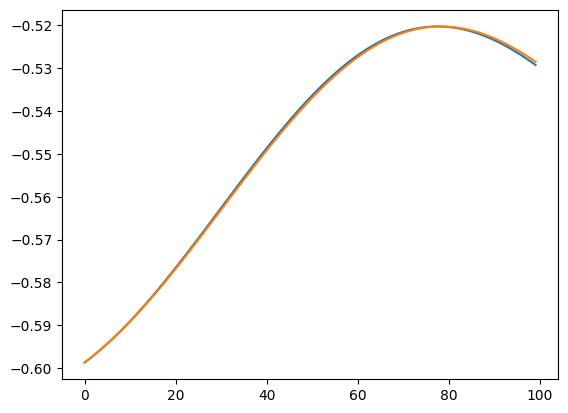

In [205]:
plt.plot(result.expect[0], label = "X1")
plt.plot(misure[0:,0,0])

In [9]:
np.array([qs.local_operators(qs.sigmax(), Nq), qs.local_operators(qs.sigmay(), Nq), qs.local_operators(qs.sigmaz(), Nq)]).reshape(12, 16,16)

array([[[ 0.+0.j,  0.+0.j,  0.+0.j, ...,  0.+0.j,  0.+0.j,  0.+0.j],
        [ 0.+0.j,  0.+0.j,  0.+0.j, ...,  0.+0.j,  0.+0.j,  0.+0.j],
        [ 0.+0.j,  0.+0.j,  0.+0.j, ...,  0.+0.j,  0.+0.j,  0.+0.j],
        ...,
        [ 0.+0.j,  0.+0.j,  0.+0.j, ...,  0.+0.j,  0.+0.j,  0.+0.j],
        [ 0.+0.j,  0.+0.j,  0.+0.j, ...,  0.+0.j,  0.+0.j,  0.+0.j],
        [ 0.+0.j,  0.+0.j,  0.+0.j, ...,  0.+0.j,  0.+0.j,  0.+0.j]],

       [[ 0.+0.j,  0.+0.j,  0.+0.j, ...,  0.+0.j,  0.+0.j,  0.+0.j],
        [ 0.+0.j,  0.+0.j,  0.+0.j, ...,  0.+0.j,  0.+0.j,  0.+0.j],
        [ 0.+0.j,  0.+0.j,  0.+0.j, ...,  0.+0.j,  0.+0.j,  0.+0.j],
        ...,
        [ 0.+0.j,  0.+0.j,  0.+0.j, ...,  0.+0.j,  0.+0.j,  0.+0.j],
        [ 0.+0.j,  0.+0.j,  0.+0.j, ...,  0.+0.j,  0.+0.j,  0.+0.j],
        [ 0.+0.j,  0.+0.j,  0.+0.j, ...,  0.+0.j,  0.+0.j,  0.+0.j]],

       [[ 0.+0.j,  0.+0.j,  1.+0.j, ...,  0.+0.j,  0.+0.j,  0.+0.j],
        [ 0.+0.j,  0.+0.j,  0.+0.j, ...,  0.+0.j,  0.+0.j,  0.+0.j],
    

In [ ]:
state = qs.zero(dm = True, N = 4)
H0 = qs.sigmaz()
cops = []
state_t = qs.QRC.CD_evolution(np.random.random((100)), H1, H0, 0.1, 100, state)

AttributeError: module 'QuantumStuff' has no attribute 'local_operator'

In [ ]:
import warnings

import warnings

warnings.filterwarnings(
    action='ignore',
    category=RuntimeWarning,
    message=r'.*invalid value encountered in log2.*'
)

def von_neumann_entropy(state: np.ndarray):
    """
    Calculate the von Neumann entropy of a quantum state.
    The von Neumann entropy is defined as:
        S(ρ) = -Tr(ρ log2(ρ))

    where ρ is the density matrix of the quantum state.
    Args:
        state (np.ndarray): The quantum state, can be a density matrix or a pure state.
        ax (int): Axis along which to compute the entropy. Default is -1.
    Returns:
        np.ndarray: The von Neumann entropy of the state.
    """

    check = qs.is_state(state)
    if not check[1]:
        raise Exception("Input is not a valid quantum state")
    if check[0] != 3:
        state = qs.ket_to_dm(state)

    state = np.asarray(state, dtype = complex)

    eigs = np.linalg.eigvalsh(state)
    entropy = np.sum(-eigs * np.log2(eigs), axis = -1)
    if np.shape(entropy) == ():
        entropy = np.array([entropy])
    entropy[np.where(np.isnan(entropy))] = 0
    return entropy

state = qs.random_qubit(3, pure = False, dm = True) 
von_neumann_entropy(state)

array([2.37654684])

In [558]:
state = [qs.random_qubit(3, pure = True, dm = True) for i in range(10)]

np.any(np.isclose(np.linalg.eigvalsh(state), 1), axis = -1)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [228]:
H_test = np.sum([[J[i,j]*np.dot(z[i],z[j] )for i in range(3)] for j in range(3)], axis = (0,1))

In [229]:
np.allclose(H,H_test)

True

In [11]:
state = [qs.random_qubit(4, pure = True, dm = True) for i in range(10)]
qs.is_state(state)

(3, True)

In [5]:
qs.CD_evolution(np.random.random(10),qs.sigmax(), qs.sigmaz(), [qs.sigmay()], 0.1,  5, ρ = None, disable_progress_bar = False)

100%|██████████| 5/5 [00:00<00:00, 714.09it/s]


array([[[0.88563915-3.69494902e-26j, 0.01432705+1.46380481e-01j],
        [0.01432705-1.46380481e-01j, 0.11436085+3.73647723e-26j]],

       [[0.75999731-3.00523769e-26j, 0.04775592+2.40364020e-01j],
        [0.04775592-2.40364020e-01j, 0.24000269+3.38090441e-26j]],

       [[0.63323971-1.42454260e-19j, 0.08810637+2.90456364e-01j],
        [0.08810637-2.90456364e-01j, 0.36676029+1.46690436e-19j]],

       [[0.52064962-7.48714072e-19j, 0.12576854+2.93737455e-01j],
        [0.12576854-2.93737455e-01j, 0.47935038+7.60588079e-19j]],

       [[0.42013505-1.86174175e-18j, 0.15307276+2.53030154e-01j],
        [0.15307276-2.53030154e-01j, 0.57986495+1.94392272e-18j]]])

In [79]:
state = qs.random_qubit(4, pure = True, dm = True)
meas = measure([state]*10, [qs.sigmax()]*3)
measure2 = qs.measure(state, [np.kron(qs.sigmaz(), qs.sigmaz())]*5)
meas.shape

(10, 3, 4)

In [11]:
a = np.random.random((2,4,4))
b = np.random.random((3,4,4))
(a[:, np.newaxis]@b[np.newaxis,:]).shape

(2, 3, 4, 4)

In [3]:
from tqdm import tqdm
N = 5
Js = 1
J = qso.random_coupling(Js, N)
X = qs.local_operators(qs.sigmax(), N)
Z = qs.local_operators(qs.sigmaz(), N)
h = 0.1
H0 = np.sum(qso.interaction(X, J) + h*Z ,0)
H1 = h*np.sum(X,0)
stato = qs.random_qubit(N, pure = True, dm = True)
ρ = stato
σm = qs.local_operators(qs.sigmam(), N)

states = []
dt = 10/370
ρt = np.zeros((370,2**N,2**N), dtype = complex)
    
sh = sp.csc_matrix(qso.Super_H(H0), dtype = complex)
sd = sp.csc_matrix(qso.Super_D(σm), dtype = complex)

def Lindblad_Propagator(SH: np.ndarray | sp.csc_matrix, SD: np.ndarray | sp.csc_matrix, dt: float, ρ: np.ndarray):
    """
    Lindblad propagator for Lindblad equation
    :L: super operator
    :dt: time step
    :ρ: density matrix
    :return: propagated density matrix
    """
    L = SH + SD
    is_sparse = type(L) == sp.csc_matrix or sp.csc_array
    if ρ.ndim != 1:
        ρ = ρ.flatten()
    if is_sparse:
        return expm_multiply(L, ρ, start = 0 , stop = dt, num = 2)[-1]
    else:
        return expm(L * dt) @ ρ
    
def CD_evolution(sk: np.ndarray, H1: np.ndarray | sp.csc_matrix | sp.csc_array, H0: np.ndarray | sp.csc_matrix | sp.csc_array, c_ops: list, δt: float,  steps: int, ρ = None):
    #Evolution
    Nq = int(np.log2(H0.shape[0]))
    superd = sp.csc_matrix(qso.Super_D(c_ops), dtype = complex)
    if ρ is None:
        ρ = qso.zero(dm = True, N = Nq)
    ρt = np.zeros((steps, 2**Nq, 2**Nq), dtype = complex)
    for i in tqdm(range(steps)):
        superh = sp.csc_matrix(qso.Super_H(H0 + (sk[i] + 1)*H1), dtype = complex)
        ρt[i] = Lindblad_Propagator(superh, superd, δt, ρ).reshape(2**Nq, 2**Nq)
        ρ = ρt[i]

    return ρt
sk = np.random.random(30)
ρt = CD_evolution(sk, H1, H0, σm, dt, 30, stato)
states = (qs.measure(ρt, qs.sigmaz()))

100%|██████████| 30/30 [00:01<00:00, 22.93it/s]


In [37]:
for i in tqdm(range(10),disable=False):
    print(i)


100%|██████████| 10/10 [00:00<00:00, 1575.21it/s]

0
1
2
3
4
5
6
7
8
9


In [35]:
state = qs.random_qubit(4, pure = True, dm = False)
qs.is_state(evolve_unitary(U, state))

(3, True)

In [13]:
U = qs.haar_random_unitary(4)
state = np.array([qs.random_qubit(4, pure = True, dm = True) for i in range(5)])
qs.is_state(U@state@qs.dag(U))

(3, True)

In [ ]:
state = np.array([qs.random_qubit(4, pure = True, dm = False) for i in range(5)])
np.outer(state, qs.dag(state))

(80, 80)

In [22]:
rho = np.array(qs.random_qubit(4, pure = True, dm = False) )
if rho.ndim == 1 or (rho.shape[0] != rho.shape[1] and rho.ndim == 2):
    print('porcodio')
    rho = qs.ket_to_dm(rho)


porcodio


In [3]:
state_ivp = qs.evolve_lindblad(stato, H, np.arange(0, 10, 10/370), c_ops = σm)

In [ ]:
[0,dt]

array([0.])

In [61]:
c_ops = [qt.Qobj(c, dims = [[2 for i in range(N)] for j in range(2)]) for c in σm]
eops = [qt.Qobj(e, dims = [[2 for i in range(N)] for j in range(2)]) for e in (Z)]
H0 = qt.Qobj(H0, dims = [[2 for i in range(N)] for j in range(2)])
H1 = qt.Qobj(H1, dims = [[2 for i in range(N)] for j in range(2)])

stato = qt.Qobj(stato, dims = [[2 for i in range(N)] for j in range(2)])
state_qutip = np.zeros((30,5), dtype = complex)
for k in tqdm(range(30)):
    state_update = qt.mesolve(H0 + (1+sk[k])*H1, stato, [0,dt], c_ops = c_ops, e_ops = eops, options = {'store_final_state': True})
    stato = state_update.final_state
    state_qutip[k] = np.array(state_update.expect)[:,-1]

100%|██████████| 30/30 [01:00<00:00,  2.01s/it]


In [57]:
np.array(state_update.expect)[:,-1]

array([-0.19260371, -0.20577622,  0.10719096,  0.01785502, -0.05879561])

In [14]:
m_qtp = state_qutip.expect

In [6]:
state_ivp = state_ivp.T.reshape(370, 2**5, 2**5)


In [35]:
state_qutip.shape

(370, 32, 32)

In [62]:
# m_ivp = qs.measure(state_ivp, qs.sigmax())
m_qso = qs.measure(ρt, qs.sigmaz())
# m_qutip = qs.measure(state_qutip, qs.sigmaz())


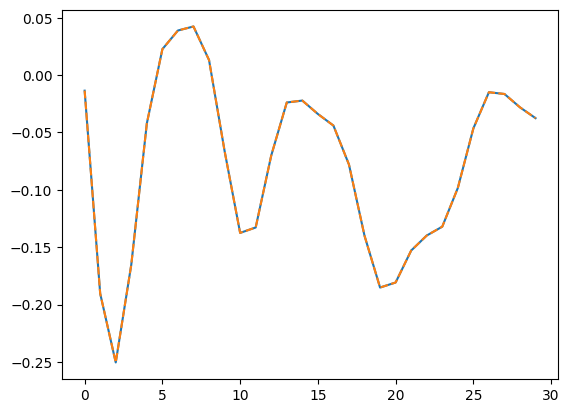

In [64]:
import matplotlib.pyplot as plt

# plt.plot(m_ivp[:,0,0],'.')
plt.plot(states[:,0,1])
# plt.plot(m_qutip[0,0,:,0],'.')
plt.plot(np.array(state_qutip)[:,1],'--')

In [36]:
np.array(m_qso).shape

(370, 1, 5)